In [73]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from openpyxl import Workbook

## Data import

In [74]:
start = 1
end = 15
print([str(x) for x in range(start, end) if x % 2 == 0])
print([str(x) for x in range(start, end) if x % 2 == 1])

['2', '4', '6', '8', '10', '12', '14']
['1', '3', '5', '7', '9', '11', '13']


In [75]:
data_folder = 
DAY = "2021_11_03"  # Manually change

iv_file_ids = ['01', '03', '06', '08', '10', '12', '14']  # Manually change ids
iv_files = [DAY + "_00{}".format(value) for value in iv_file_ids]

cc_file_ids = ['02', '05', '07', '09', '11', '13']
cc_files = [DAY + "_00{}".format(value) for value in cc_file_ids]

## Functions

In [76]:
def c1_Vm(sweep_Y_data, c1):
    """Returns the Vm at the cursor 1 position.

    Keyword arguments:
    sweep_Y_data -- sweep Vm values
    c1 -- cursor 1 position in ms
    """
    return sweep_Y_data[c1]


def sweep_command(abf_data):
    """Accesses the command epoch table in abf_data (current steps in pA),
    returns a list of current injections of the first 5 sweeps."""
    # Each current step decreases by 1/4 of the initial step
    multiplier = [1, 0.75, 0.5, 0.25, 0]
    # Epochs.level index 2 gives the value of the initial command current
    current_injection = abf.sweepEpochs.levels[2]
    return [current_injection * x / 1000 for x in multiplier]  # /1000 to get nA


def c1c2_min(sweep_Y_data, c1, c2):
    """Returns the lowest point between cursor 1 and 2.

    Keyword arguments:
    sweep_Y_data -- sweep Vm values
    c1 -- cursor 1 position in ms
    c2 -- cursor 2 position in ms
    """
    return min(sweep_Y_data[c1:c2])


def c3c4_min(sweep_Y_data, c3, c4):
    """Returns the lowest point between cursor 3 and 4.

    Keyword arguments:
    sweep_Y_data -- sweep Vm values
    c3 -- cursor 3 position in ms
    c4 -- cursor 4 position in ms
    """
    return min(sweep_Y_data[c3:c4])


def peaks(sweep_X_data, sweep_Y_data, threshold):
    """Returns peak indices for each sweep.

    Keyword arguments:
    sweep_X_data -- sweep time values
    sweep_Y_data -- sweep Vm values
    threshold -- minimum detection threshold (in mV)
    """

    # Array of all sweep_Y_data[i+1] - sweep_Y_data[i]
    dvdt = np.diff(sweep_Y_data)
    peak_indices = [i
                    for i, value in enumerate(dvdt)
                    if sweep_Y_data[i] > threshold 
                    and all(dvdt[i: i + 7] <= 0)
                    and all(dvdt[i - 7: i] > 0)]
    return peak_indices

## IV plots

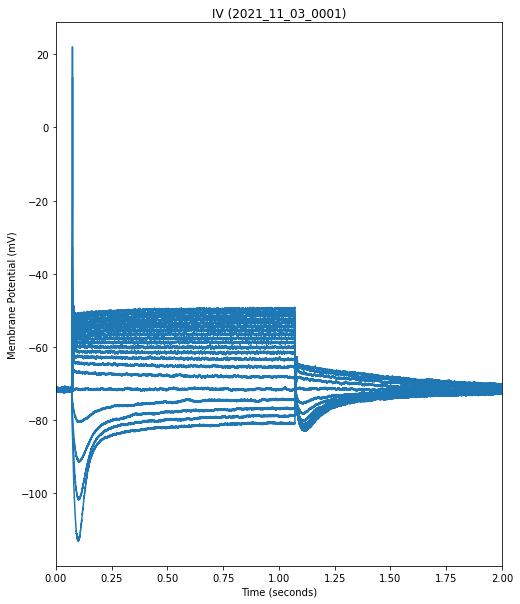

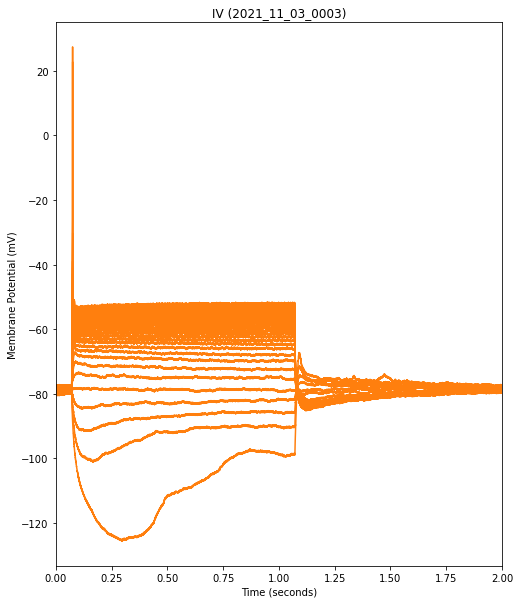

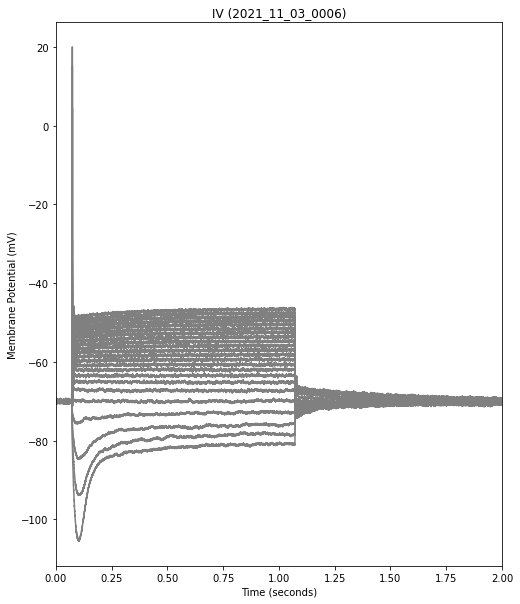

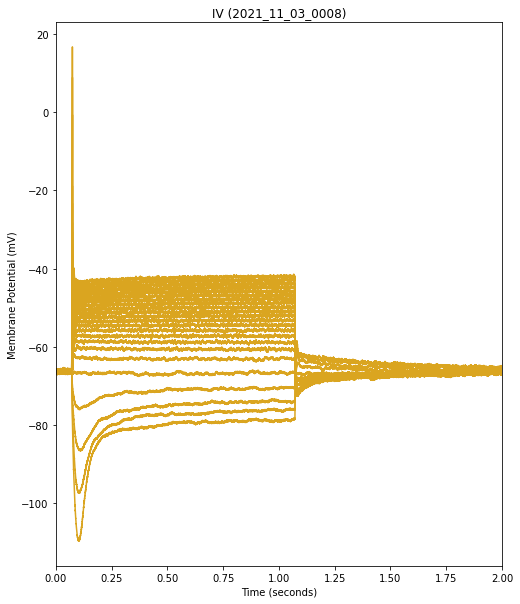

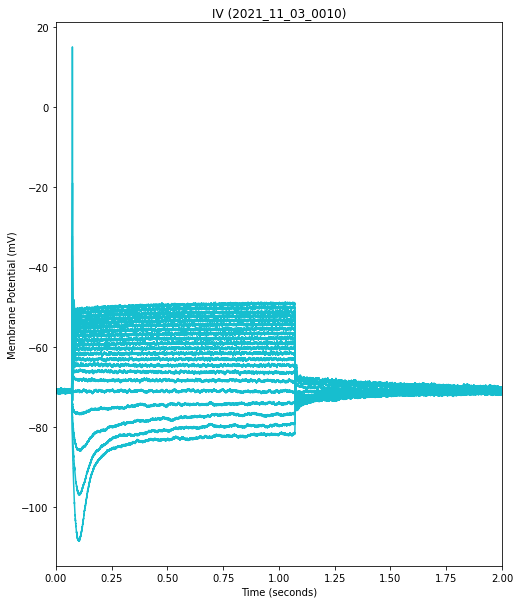

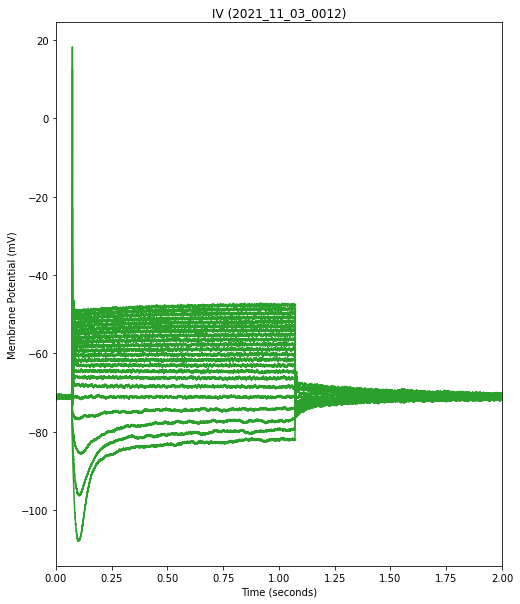

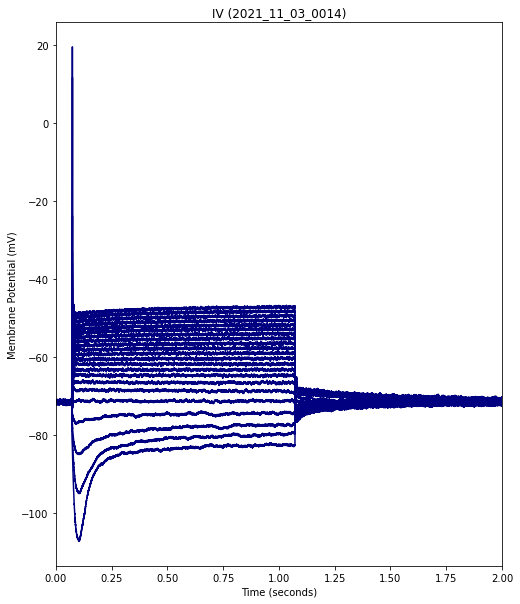

In [77]:
#  use a custom colourmap to create a different colour for every sweep
#  add name of colourmap in: cmap = mpl.cm."HERE" (e.g. viridis,winter,rainbow,magma,BuGn,tab10,cividis)
#  cmap = colourmap as a matrix of colours and then select a part of this matrix as your new colourmap

#cmap = mpl.cm.tab10(np.linspace(0, 1, 20))
#cmap = mpl.colors.ListedColormap(cmap[0:, :-1])  # change first iv_file_name from 0-19
#colours = [cmap(x / len(iv_files)) for x in abf.sweepList]
#colours.reverse()

colours = [
    "tab:blue",
    "tab:orange",
    "grey",
    "goldenrod",
    "tab:cyan",
    "tab:green",
    "navy",
]

threshold = 10  # deteciton threshold for peaks

for count, iv_file_name in enumerate(iv_files):
    path = data_folder + DAY + "/" + iv_file_name + ".abf"
    abf = pyabf.ABF(path)  # One IV file

    fig = plt.figure(figsize=(8, 10))
    single_colour = colours[count]

    plt.title("IV ({})".format(iv_file_name))
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)

    for i in range(abf.sweepCount):
        abf.setSweep(i)  # One sweep
        
        plt.plot(
            abf.sweepX,
            abf.sweepY,
            alpha=1,
            # label="sweep {}".format(i + 1),
            color=single_colour,
        )
        #if i >= 5:  # ignore first 5 traces
            #peak_i = peaks(abf.sweepX, abf.sweepY, threshold)
            #plt.plot(abf.sweepX[peak_i], abf.sweepY[peak_i], 'ro')
    plt.xlim([0, 2])
    # plt.legend()

    plt.savefig(data_folder + DAY + "/" + "IV " + iv_file_name, dpi=300, bbox_inches="tight")
    plt.show()

## CC plots

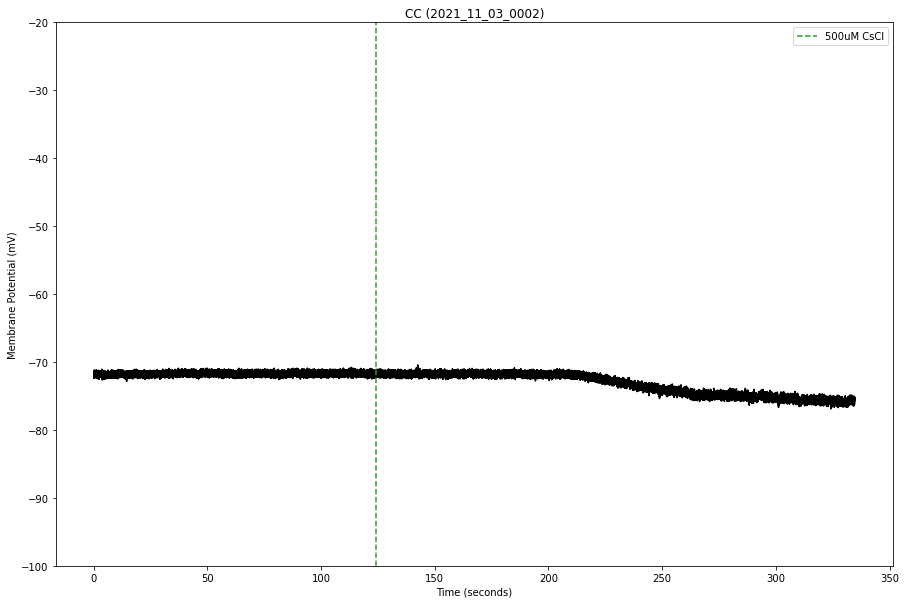

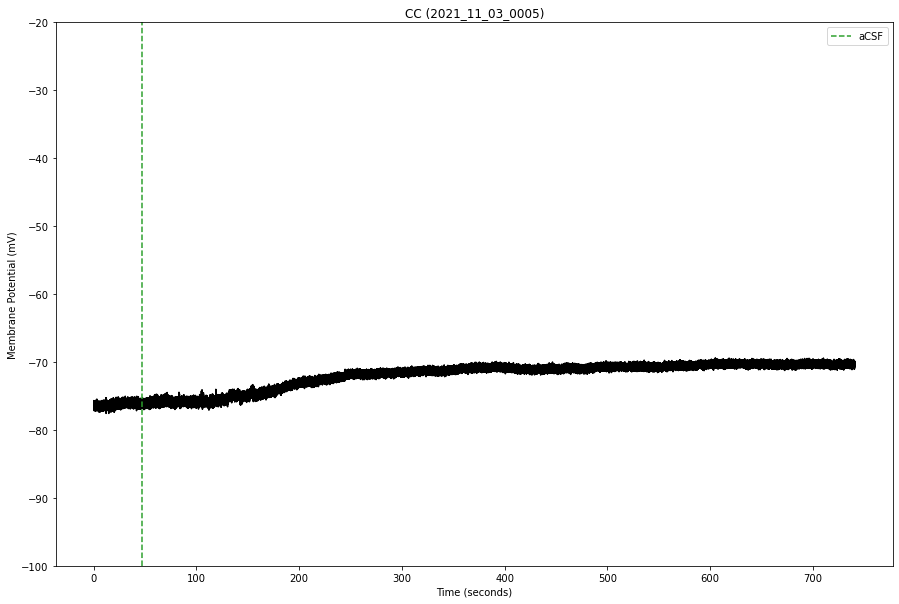

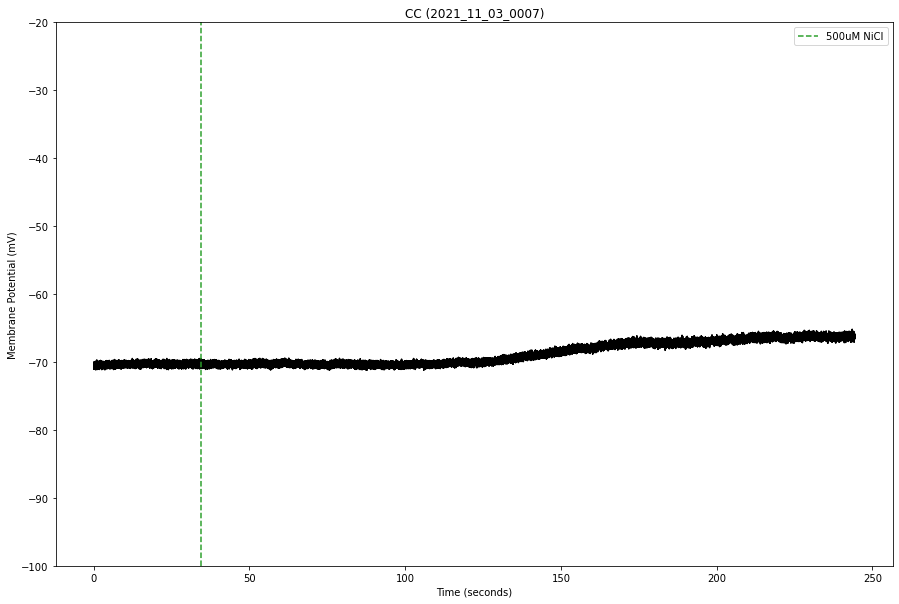

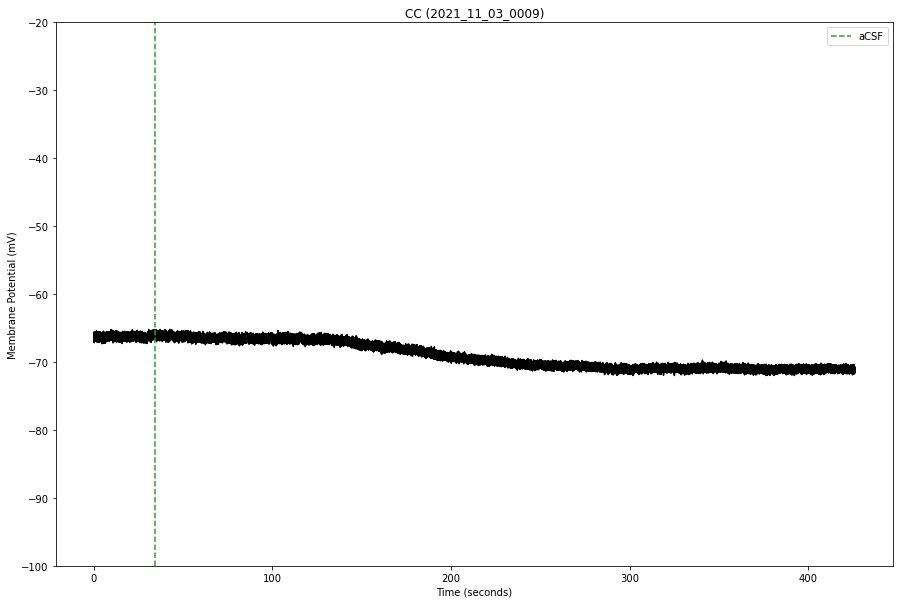

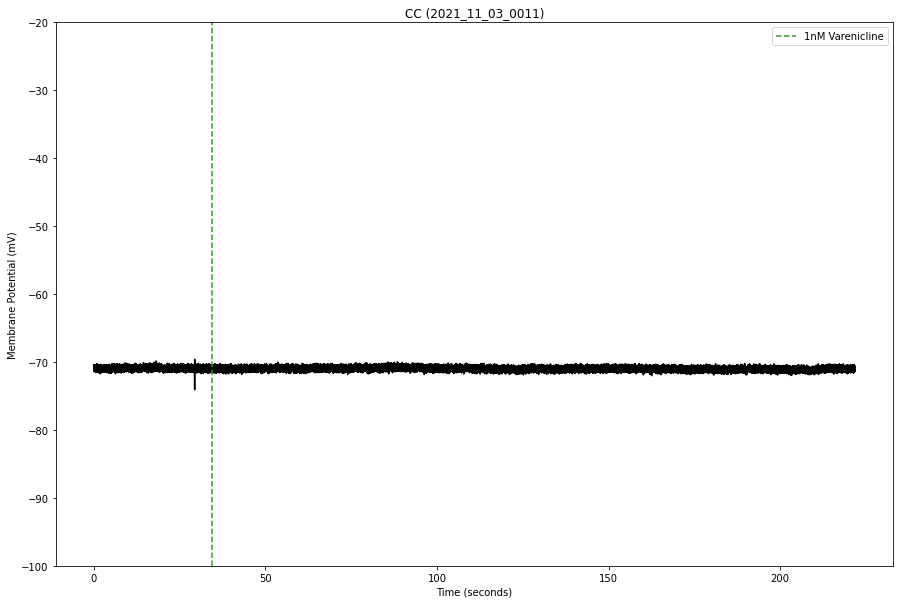

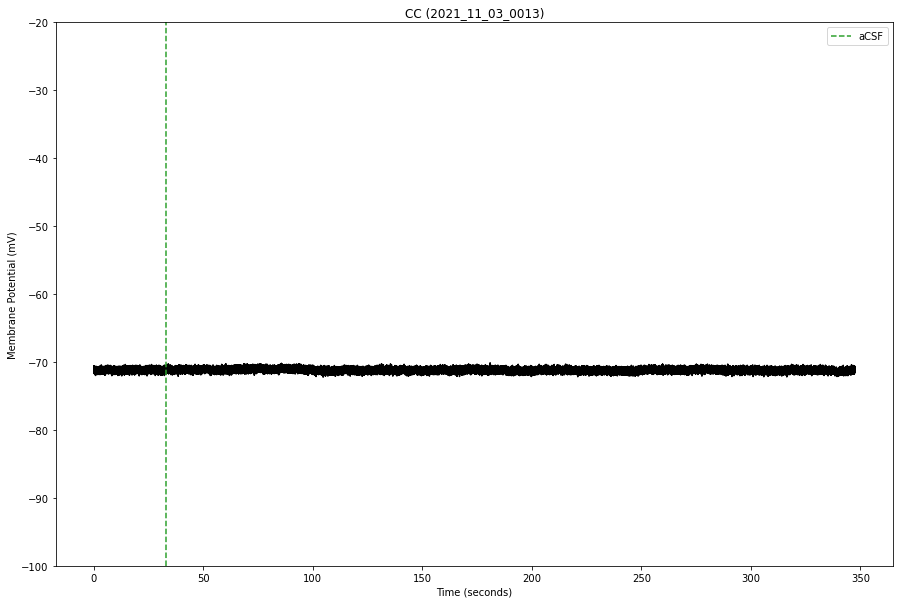

In [78]:
for count, cc_file_name in enumerate(cc_files):
    path = data_folder + DAY + "/" + cc_file_name + ".abf"
    abf = pyabf.ABF(path)

    fig = plt.figure(figsize=(15, 10))

    plt.title("CC ({})".format(cc_file_name))
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)

    for i in range(abf.sweepCount):
        abf.setSweep(i, absoluteTime=True)  # <-- relates to sweepX
        plt.plot(
            abf.sweepX,
            abf.sweepY,
            alpha=1,
            # label="sweep {}".format(i + 1),
            color="black",
        )
    plt.ylim([-100, -20])
    # plt.legend()
    
    for i, tagTimeSec in enumerate(abf.tagTimesSec):
        posX = abf.tagTimesSec[i]
        comment = abf.tagComments[i]
        color = "C{}".format(i+2)
        plt.axvline(posX, label=comment, color=color, ls='--')
    plt.legend()
    
    
    plt.savefig(data_folder + DAY + "/" + "CC " + cc_file_name, dpi=300, bbox_inches="tight")
    plt.show()

## IV analysis

In [79]:
cursor_1 = 298  # Cursor position in ms. Values obtained from Excel.
cursor_2 = 4181
cursor_3 = 8912
cursor_4 = 10747
threshold = 10  # deteciton threshold for peaks

wb = Workbook()
ws = wb.active
for count, iv_file_name in enumerate(iv_files):
    path = data_folder + DAY + "/" + iv_file_name + ".abf"
    abf = pyabf.ABF(path)  # One IV file

    rmp = []
    current_injection = sweep_command(abf)
    ih = []
    ss = []
    peak_i = []
    sweep_firstAP = "No AP"
    for i in range(abf.sweepCount):
        abf.setSweep(i)  # One sweep
        if i <= 4: # sweeps between 1-5
            rmp.append(c1_Vm(abf.sweepY, cursor_1))
            ih.append(c1c2_min(abf.sweepY, cursor_1, cursor_2))
            ss.append(c3c4_min(abf.sweepY, cursor_3, cursor_4))
        elif peak_i == []:  # sweeps > 5. Finds the first peaks in the IV recording
            peak_i = peaks(abf.sweepX, abf.sweepY, threshold)
            
        if sweep_firstAP == "No AP" and peak_i != []:
            sweep_firstAP = i+1
            print("IV {}.".format(iv_file_name), "Sweep with first AP:", sweep_firstAP) 
        
    ws.cell(row=29, column=count * 5 + 2, value=sweep_firstAP)
    
    results = [rmp, current_injection, ih, ss]
    for col, data in enumerate(results):
        for j, datum in enumerate(data):
            ws.cell(row=j + 5, column=col + 1 + count * 5, value=datum)
            
    

wb.save(filename="C:/Users/abdij/OneDrive - University of Warwick/Desktop/ATF data/Results_copy.xlsx")

IV 2021_11_03_0001. Sweep with first AP: 19
IV 2021_11_03_0003. Sweep with first AP: 26
IV 2021_11_03_0006. Sweep with first AP: 22
IV 2021_11_03_0008. Sweep with first AP: 23
IV 2021_11_03_0010. Sweep with first AP: 21
IV 2021_11_03_0012. Sweep with first AP: 21
IV 2021_11_03_0014. Sweep with first AP: 21
